In [7]:
%matplotlib inline
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16
mpl.rcParams['font.family'] = 'sans-serif'

Now we consider a Chabrier IMF. Since the form is more complicated, I resorted to numerically integrating to get the CDF (instead of the erf way). I then do a linear interpolation to map a random uniform interval onto the inverted CDF to get the sample.

In [8]:
def chabrier_imf(m):
    return 0.15/m*np.exp(-(np.log(m)-np.log(0.08))**2/(2.*0.69)**2)

c = integrate.quad(chabrier_imf,0.5,0.8)[0]

def chabrier_cdf(m):
    return integrate.quad(chabrier_imf,0.5,m)[0]/c

In [9]:
masses = np.exp(1)**np.linspace(-.693147,-.223144,num=100000)
cdf = [chabrier_cdf(m) for m in masses]

def inv_cdf(p):
    index = int(np.ceil(100000.*p)-1)
    return masses[index]

In [10]:
def imf_sample(num):
    unif = np.random.rand(num)
    return [inv_cdf(i) for i in unif]

In [11]:
sample = imf_sample(10000)

The likelihood and prior are identical to that in problem 2 with fewer constraints since we are given a minimum and maximum mass.

In [23]:
def lnprior(alpha):
    if alpha < 0:
        return -np.inf
    return 0.0
def lnlikelihood(alpha,masses):
    a1 = 1.-alpha
    c = a1/(.8**a1-.5**a1)
    return np.sum(-alpha*np.log(masses)+np.log(c))
def lnposterior(alpha,masses):
    return lnlikelihood(alpha,masses)

In [24]:
nwalkers = 10
ndim = 1
p0 = [np.random.rand(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnposterior,args=([sample]))
pos, prob, state = sampler.run_mcmc(p0,100)
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos,1000)
#print(p0)

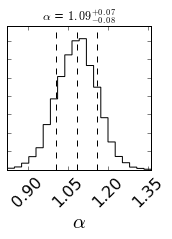

In [30]:
fig = corner.corner(sampler.flatchain,quantiles=[.16,.5,.84],show_titles=True,labels=[r'$\alpha$'])

From this we see that 